In [1]:
import numpy as np
import pandas as pd 
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
from keras.models import load_model

Total Data : 54338
Bukan Dewasa : 27192
Dewasa : 27146


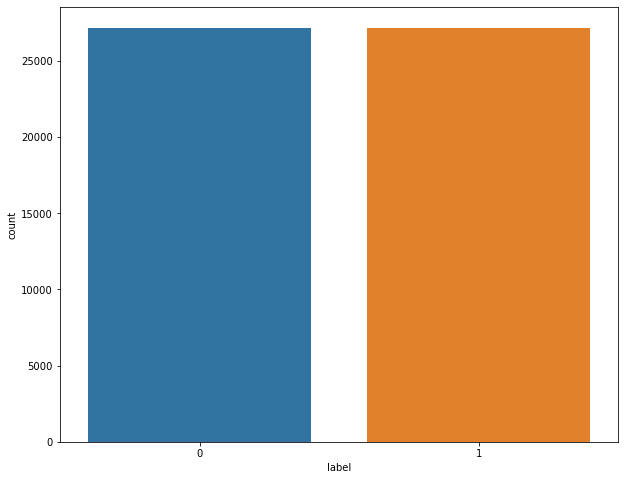

In [2]:
data = pd.read_excel("data/label/combineSSL1.xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True) # memastikan tidak ada nilai yang kosong
dewasa = data.loc[data['label'] == 1, 'tweet'].copy().reset_index(drop=True)
bukan = data.loc[data['label'] == 0, 'tweet'].copy().reset_index(drop=True)
print("Total Data :", len(data))
print("Bukan Dewasa :", len(bukan))
print("Dewasa :", len(dewasa))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [3]:
# Splitting Data
text = data['tweet'].values
label = data['label'].values
data_train, data_test, label_train, label_test = train_test_split(text, label, test_size=0.33, random_state=42)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size= 0.33, random_state=42)

In [4]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab = max([len(tokenizer.word_index)]) + 1 # kamus kata 
maxlen = max([len(i.split()) for i in text]) # panjang input sequence
batch_size = 32 # penentuan jumlah sample yang ditraining pada tiap epoch
num_epochs = 5 # banyak iterasi pada saat training model 
initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=2)

In [5]:
#Data Train
X_train = tokenizer.texts_to_sequences(data_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = to_categorical(label_train, num_classes = 2)

#Data Test
X_test = tokenizer.texts_to_sequences(data_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_test = to_categorical(label_test, num_classes = 2)

#Data Validation
X_val = tokenizer.texts_to_sequences(data_val)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_val = to_categorical(label_val, num_classes = 2)

In [6]:
def get_model1(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer)))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model2(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model3(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Dropout(0.9))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model4(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Dropout(0.9))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0,max(history.epoch)])
        
def evaluation(model, X, Y):
    # Predict the values
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    Y_act = Y
    # accuracy
    accuracy = accuracy_score(Y_act, Y_pred_class)
    print("Accuracy: %.2f" % (accuracy*100), "%")
    # precision
    precision = precision_score(Y_act, Y_pred_class)
    print("Precision: %.2f" % (precision*100), "%")
    # recall
    recall = recall_score(Y_act, Y_pred_class)
    print("Recall: %.2f" % (recall*100), "%")
    
    return Y_act, Y_pred_class

def conf_matrix(Y_act, Y_pred):
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_act, Y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d");
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [7]:
# Model 1 

In [8]:
model1 = get_model1(X_train, Y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 58, 128)           5300992   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 5,564,674
Trainable params: 5,564,674
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# training model
history1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/5
763/763 [==============================] - 143s 163ms/step - loss: 0.3265 - accuracy: 0.8303 - val_loss: 0.0585 - val_accuracy: 0.9838
Epoch 2/5
763/763 [==============================] - 136s 178ms/step - loss: 0.0346 - accuracy: 0.9908 - val_loss: 0.0721 - val_accuracy: 0.9797
Epoch 3/5
763/763 [==============================] - 128s 168ms/step - loss: 0.0135 - accuracy: 0.9968 - val_loss: 0.0819 - val_accuracy: 0.9772
Epoch 4/5
763/763 [==============================] - 119s 156ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0746 - val_accuracy: 0.9808
Epoch 5/5
763/763 [==============================] - 126s 165ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0876 - val_accuracy: 0.9814


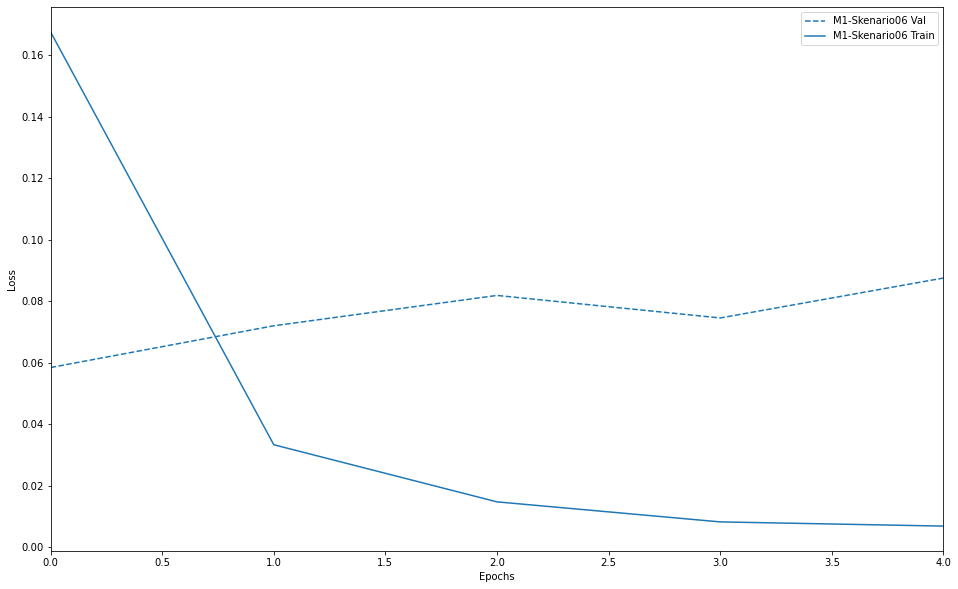

In [10]:
plot_history([('M1-Skenario06', history1)])

In [11]:
# Evaluasi 1

Evaluasi Data Test
Accuracy: 98.15 %
Precision: 97.84 %
Recall: 98.41 %


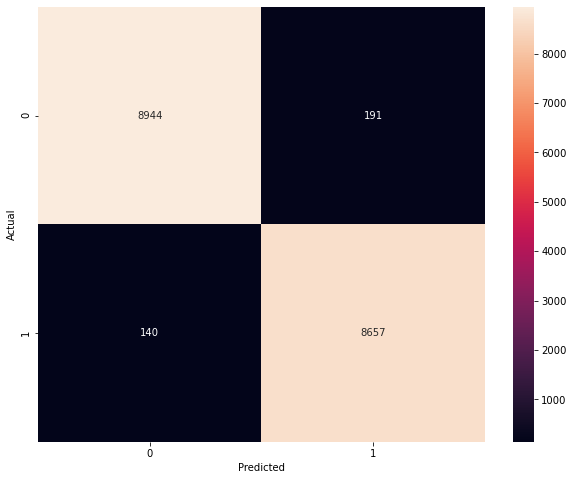

In [12]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model1, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.90 %
Precision: 99.88 %
Recall: 99.93 %


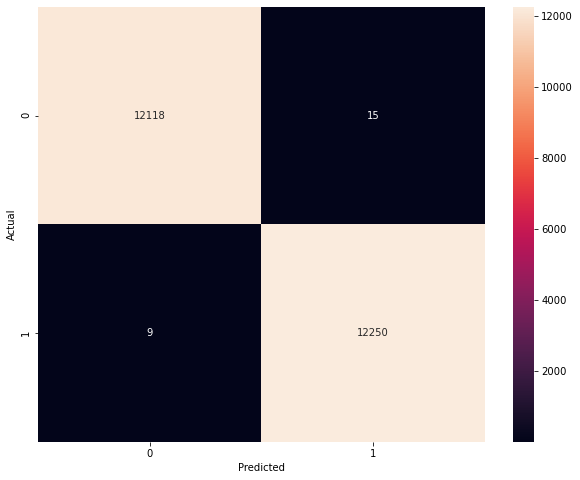

In [13]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model1, X_train, label_train)
conf_matrix(Y_act, Y_pred)

In [14]:
# Model 2

In [15]:
model2 = get_model2(X_train, Y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 58, 128)           5300992   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 58, 256)           263168    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 5,958,914
Trainable params: 5,958,914
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# training model
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/5
763/763 [==============================] - 240s 299ms/step - loss: 0.2921 - accuracy: 0.8511 - val_loss: 0.0627 - val_accuracy: 0.9831
Epoch 2/5
763/763 [==============================] - 224s 293ms/step - loss: 0.0377 - accuracy: 0.9899 - val_loss: 0.0650 - val_accuracy: 0.9833
Epoch 3/5
763/763 [==============================] - 227s 298ms/step - loss: 0.0220 - accuracy: 0.9946 - val_loss: 0.0683 - val_accuracy: 0.9795
Epoch 4/5
763/763 [==============================] - 213s 280ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.1088 - val_accuracy: 0.9719
Epoch 5/5
763/763 [==============================] - 212s 278ms/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.0904 - val_accuracy: 0.9801


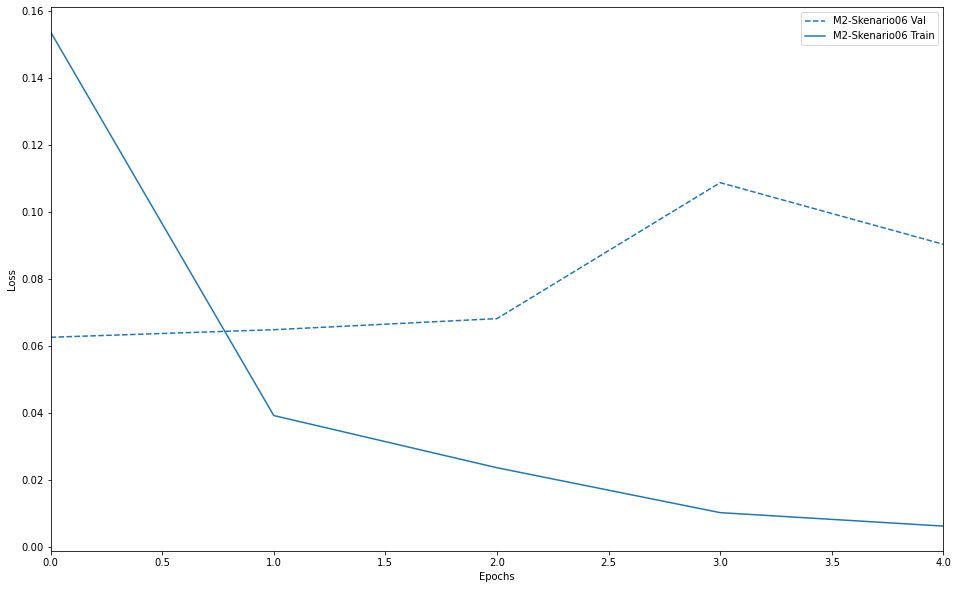

In [17]:
plot_history([('M2-Skenario06', history2)])

In [18]:
# Evaluasi 2

Evaluasi Data Test
Accuracy: 97.83 %
Precision: 97.99 %
Recall: 97.57 %


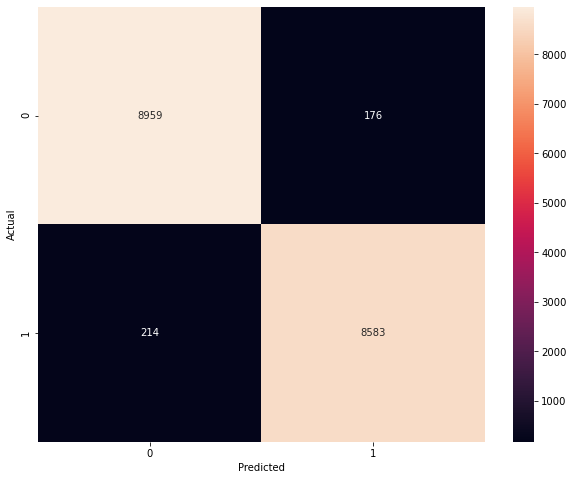

In [19]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model2, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.91 %
Precision: 99.96 %
Recall: 99.86 %


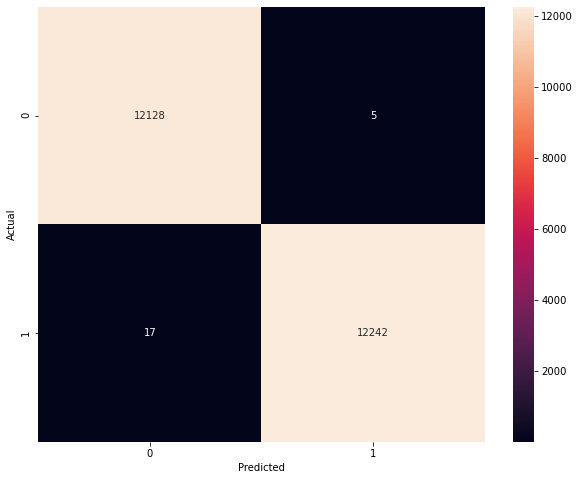

In [20]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model2, X_train, label_train)
conf_matrix(Y_act, Y_pred)

In [21]:
# Model 3

In [22]:
model3 = get_model3(X_train, Y_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 58, 128)           5300992   
_________________________________________________________________
dropout (Dropout)            (None, 58, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 5,564,674
Trainable params: 5,564,674
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# training model
history3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/5
763/763 [==============================] - 115s 146ms/step - loss: 0.4895 - accuracy: 0.7360 - val_loss: 0.0841 - val_accuracy: 0.9769
Epoch 2/5
763/763 [==============================] - 121s 159ms/step - loss: 0.0979 - accuracy: 0.9705 - val_loss: 0.0668 - val_accuracy: 0.9825
Epoch 3/5
763/763 [==============================] - 130s 170ms/step - loss: 0.0749 - accuracy: 0.9795 - val_loss: 0.0572 - val_accuracy: 0.9845
Epoch 4/5
763/763 [==============================] - 124s 163ms/step - loss: 0.0558 - accuracy: 0.9836 - val_loss: 0.0608 - val_accuracy: 0.9825
Epoch 5/5
763/763 [==============================] - 129s 169ms/step - loss: 0.0454 - accuracy: 0.9868 - val_loss: 0.0587 - val_accuracy: 0.9825


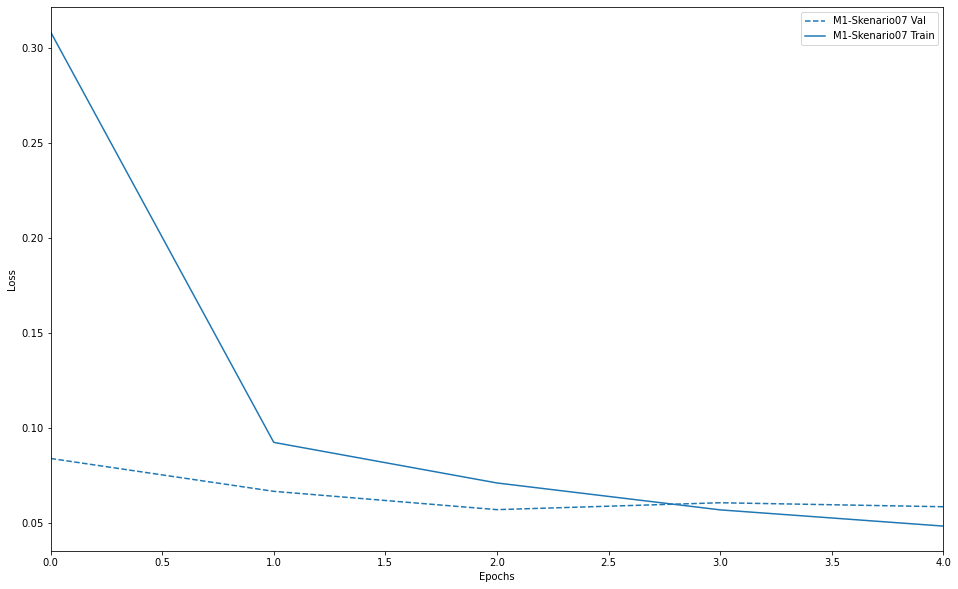

In [24]:
plot_history([('M1-Skenario07', history3)])

In [25]:
# Evaluasi 3

Evaluasi Data Test
Accuracy: 98.23 %
Precision: 97.83 %
Recall: 98.58 %


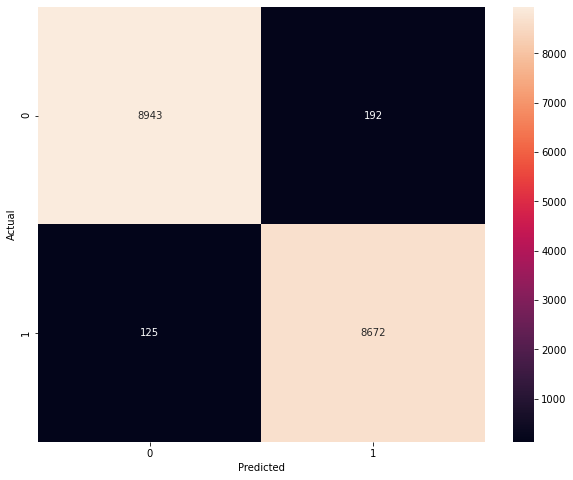

In [26]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model3, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.31 %
Precision: 99.19 %
Recall: 99.43 %


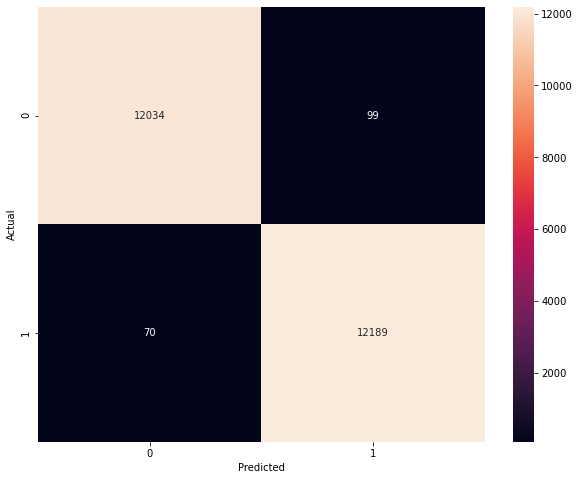

In [27]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model3, X_train, label_train)
conf_matrix(Y_act, Y_pred)

In [28]:
# Model 4

In [29]:
model4 = get_model4(X_train, Y_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 58, 128)           5300992   
_________________________________________________________________
dropout_2 (Dropout)          (None, 58, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 58, 256)           263168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 58, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [30]:
# training model
history4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/5
763/763 [==============================] - 213s 270ms/step - loss: 0.4933 - accuracy: 0.7329 - val_loss: 0.0832 - val_accuracy: 0.9747
Epoch 2/5
763/763 [==============================] - 187s 245ms/step - loss: 0.1127 - accuracy: 0.9640 - val_loss: 0.0639 - val_accuracy: 0.9833
Epoch 3/5
763/763 [==============================] - 187s 244ms/step - loss: 0.0780 - accuracy: 0.9760 - val_loss: 0.0618 - val_accuracy: 0.9827
Epoch 4/5
763/763 [==============================] - 192s 252ms/step - loss: 0.0644 - accuracy: 0.9803 - val_loss: 0.0559 - val_accuracy: 0.9829
Epoch 5/5
763/763 [==============================] - 192s 251ms/step - loss: 0.0544 - accuracy: 0.9850 - val_loss: 0.0568 - val_accuracy: 0.9824


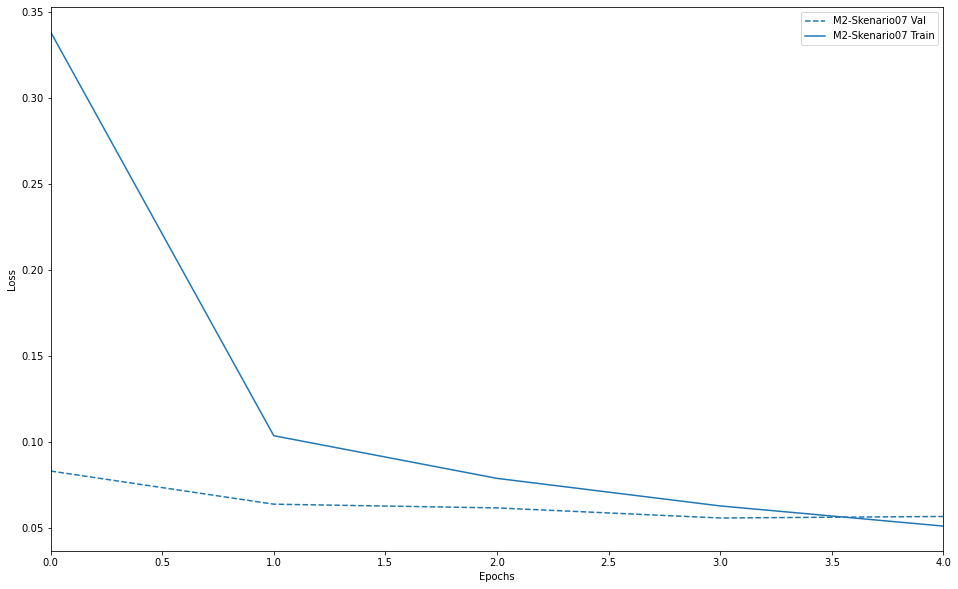

In [31]:
plot_history([('M2-Skenario07', history4)])

In [32]:
# Evaluasi 4

Evaluasi Data Test
Accuracy: 98.34 %
Precision: 97.72 %
Recall: 98.92 %


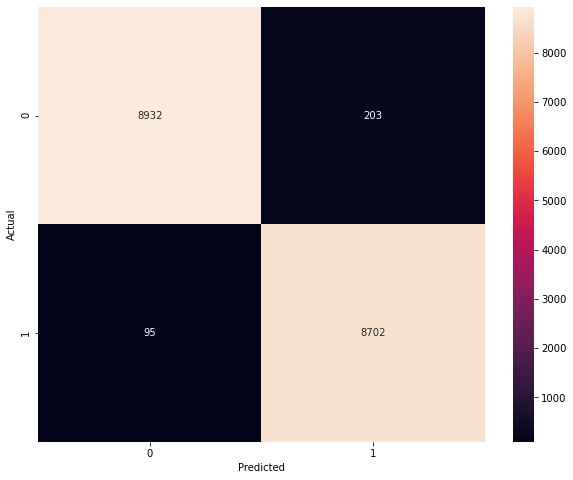

In [33]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model4, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.17 %
Precision: 98.91 %
Recall: 99.44 %


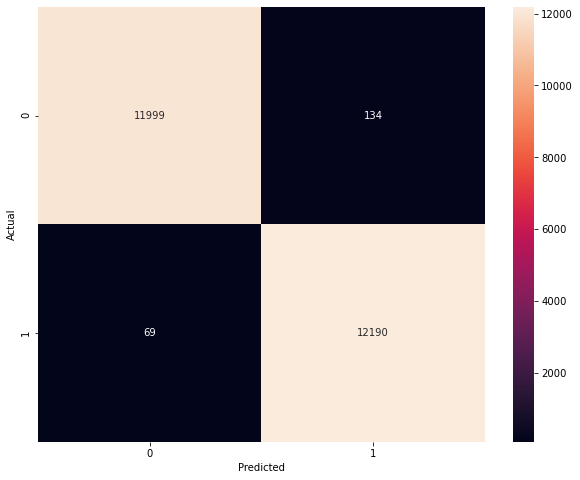

In [34]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model4, X_train, label_train)
conf_matrix(Y_act, Y_pred)

In [35]:
# Grafik Keseluruhan 

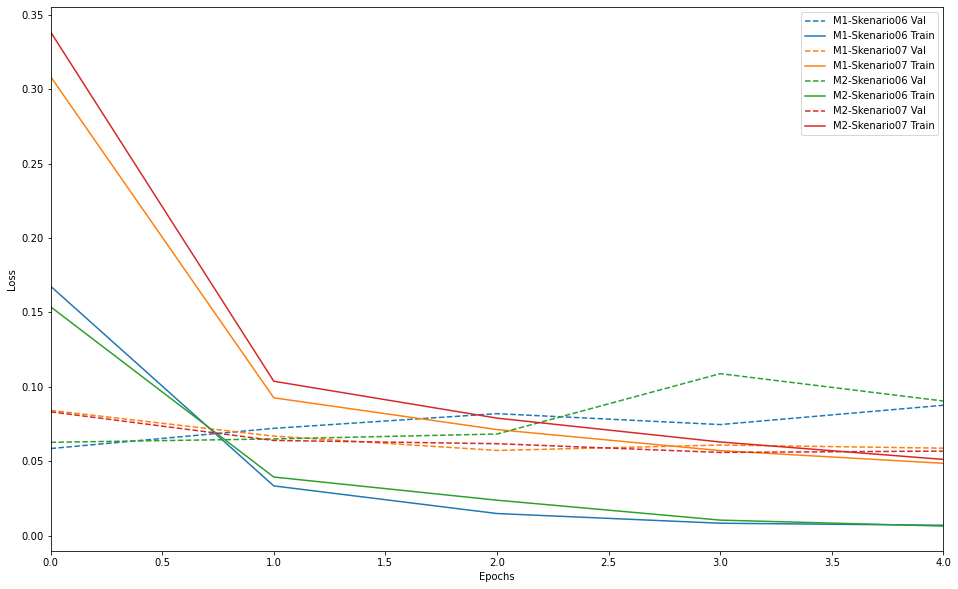

In [36]:
plot_history([
    ('M1-Skenario06', history1),
              ('M1-Skenario07', history3),
              ('M2-Skenario06', history2),
              ('M2-Skenario07', history4)])

In [37]:
# Save Model

In [38]:
model1.save('model/M1-Skenario06.h5')
model2.save('model/M2-Skenario06.h5')
model3.save('model/M1-Skenario07.h5')
model4.save('model/M2-Skenario07.h5')